In [2]:
### Imports
# General
import json
import numpy as np
import pandas as pd
# Pymatgen
from pymatgen import Structure, Element, Specie
from pymatgen.analysis.ewald import EwaldSummation
from pymatgen.analysis.local_env import BrunnerNN_reciprocal
# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

### Matplotlib style ###
mpl.rc_file('../Data/matplotlibrc')
mpl.rcParams['figure.figsize'] = (7.0,4.5)
mpl.style.use('ggplot')
clrs = ['#254654','#219e8f', '#f6a25a', '#eac563', '#e96f4c']

# Comment this out if not using LaTeX style
mpl.rc_params('text.usetex : True')

### initialize nearest-neighbour algorithm 
bnn = BrunnerNN_reciprocal()

## Oxygen Madelung site potentials in LiMO2 and Li2MO3 systems

In [3]:
# Load structures 
with open('../Data/relaxed_structures.json', 'r') as f:
    structures = json.load(f)
    
# Covert back to Pymatgen Structure objects
structures = [Structure.from_dict(i) for i in structures]
print('{} LiMO2 and Li2MO3 structures loaded.'.format(len(structures)))

48 LiMO2 and Li2MO3 structures loaded.


In order to calculate Madelung site potentials, we must add oxidation states. Various strategies exist for doing this in Pymatgen: 
1. Using the bond valence analysis module
2. Adding oxidation states by guess based on the composition
3. Manually replacing Elements for Species we want 

Approaches 1. and 2. are generally less clunky, and approach 1 can deal with mixed valence compounds. We are considering some uncommon oxidation states for certain transition metals in this example, so will use the latter approach:

In [4]:
for struc in structures:
    # Find and assign the transition metal
    tm = [m for m in struc.composition if m.symbol not in ['Li','O']][0]
    # Assign transition metal correct charge
    if struc.composition.anonymized_formula == 'AB2C3':
        tm_sp = Specie(tm.symbol, 4)
    elif struc.composition.anonymized_formula == 'ABC2':
        tm_sp = Specie(tm.symbol, 3)
    else:
        raise ValueError('Structure is not of the correct stoichiometry for this example.')
    
    # Perform species replacement     
    struc.replace_species({'Li': 'Li+', 'O': 'O2-', tm: tm_sp})

We now use the `EwaldSummation` class to calculate madelung site potentials. We use a function to do this.

In [5]:
def get_madelung_site_pots(struc, el_symbol, Li_coord=None):
    ''' Calculates the average Madelung site potentials for a 
    chosen element in a structure. Returns either a np.array of 
    Madelung potentials or an average. Converts negative
    energy to positive potential for convention.
    Args:
        struc: Pymatgen structure object. 
        el_symbol (str): Symbol for which species we want to 
        calculate madelung potential.
        Li_coord (int): If supplied, only the madelung potentials
        of atoms with a specific Li-coordination number will be 
        included in the avergage. 
    '''
    # Straightforward option if all coordination envs considered
    ews = EwaldSummation(struc)
    if not Li_coord:
        indices = [n for n,site in enumerate(struc) 
                     if site.specie.symbol==el_symbol]
        mads = np.array([ews.get_site_energy(n) for n in indices])
        
    # Perform the nearest neighbour analysis if Li_coord supplied    
    else:
        mads = []
        n_sites = 0
        for n,site in enumerate(struc):
            if site.specie.symbol == el_symbol:
                nearest_neighbours = bnn.get_nn_info(struc,n)
                n_Li = len([s['site'].specie for s in nearest_neighbours 
                            if s['site'].specie.symbol == 'Li'])
                if n_Li == Li_coord:
                    mads.append(ews.get_site_energy(n))
                    n_sites+=1
        print('{} sites with Li coordination of {}'.format(n_sites,Li_coord))
    
    # Take the mean of the negatives of energies to get potential in V
    mads = np.mean(np.array(mads)*-1)

    return(mads)

In [6]:
# Calculate average O madelung site potentials for each structure
results = []
for struc in structures:
    # Calculate madelung potential
    ave_O_mad = get_madelung_site_pots(struc, 'O')
    # We also get the transition metal for plotting later
    tm = [m for m in struc.composition if m.symbol not in ['Li','O']][0]
    # Put everything in the list of results as a dict
    results.append({'structure': struc,
                    'O_mad': ave_O_mad,
                    'TM': tm.symbol})

Finally, plot the average O Madelung site potentials.

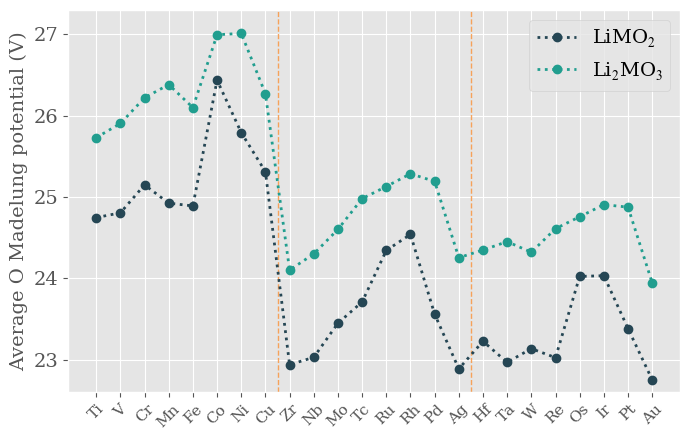

In [7]:
# Create 2 list of data
LiMO2 = [i for i in results if i['structure'].composition.anonymized_formula=='ABC2']
Li2MO3 = [i for i in results if i['structure'].composition.anonymized_formula=='AB2C3']

# x-axis
x_data, x_labels = range(len(LiMO2)), [i['TM'] for i in results]

# Plot each set of data on the same axes
for system, col, label in zip([LiMO2, Li2MO3], [clrs[0], clrs[1]], ['LiMO$_2$', 'Li$_2$MO$_3$']):
    y_data = [i['O_mad'] for i in system]
    plt.plot(x_data, y_data, marker='o', c=col, label=label, ls='dotted')
    
# x ticks
plt.tick_params(axis='x', which='major', labelsize=11)
plt.xticks(x_data, x_labels, rotation=45)

# y ticks and label
plt.tick_params(axis='y', which='major', labelsize=14)
plt.ylabel('Average O Madelung potential (V)', size=14)

# y axis limits
ymin, ymax = 22.6, 27.3
plt.ylim(ymin,ymax)

# add some vertical lines to break up rows of periodic table
plt.vlines(7.5, ymax=ymax, ymin=ymin, color=clrs[2], linewidth=1, linestyle='--')
plt.vlines(15.5, ymax=ymax, ymin=ymin, color=clrs[2], linewidth=1, linestyle='--')

# legend, layout, save 
plt.legend(prop={'size':14})
plt.tight_layout()
plt.savefig('../Figures/LiMO2-Li2MO3-O-madelung-potentials.png', dpi=300)
plt.show()

## Effect of Li:M ratio on O Madelung site potential in disordered supercells
We use 128 atom supercells of the LiMO2 structures (M = Ti, V, Cr, Mn, Fe), which have some Li/Mn disorder. These were generated using the open-source python package [Transformer](https://github.com/JMSkelton/Transformer), and have random distributions of O different environments. 

We plot the average Madelung site potential for different OMn$_n$Li$_{6-n}$ environments, where n = 2,3,4.

Ti
12 sites with Li coordination of 2
40 sites with Li coordination of 3
12 sites with Li coordination of 4
V
17 sites with Li coordination of 2
31 sites with Li coordination of 3
15 sites with Li coordination of 4
Cr
10 sites with Li coordination of 2
44 sites with Li coordination of 3
10 sites with Li coordination of 4
Mn
5 sites with Li coordination of 2
54 sites with Li coordination of 3
5 sites with Li coordination of 4
Fe
8 sites with Li coordination of 2
48 sites with Li coordination of 3
8 sites with Li coordination of 4


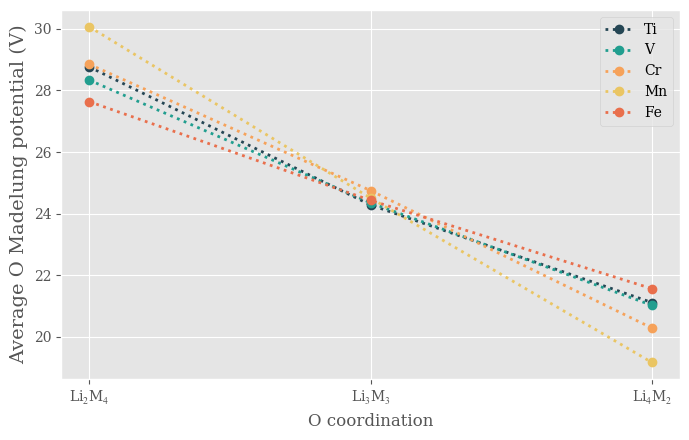

In [8]:
for n, tm in enumerate(['Ti','V','Cr','Mn','Fe']):
    struc = Structure.from_file('../Data/supercells/Li{}O2_supercell.vasp'.format(tm))
    struc.add_oxidation_state_by_guess()
    print(tm)

    # Calculate madelung potentials
    mad_2, mad_3, mad_4 = get_madelung_site_pots(struc, 'O', 2),\
                          get_madelung_site_pots(struc, 'O', 3),\
                          get_madelung_site_pots(struc, 'O', 4),

    # Add data points to plot
    plt.plot([2,3,4],[ mad_2, mad_3, mad_4],marker='o', 
         c=clrs[n], ls='dotted', label=tm)

# Plot aesthetics and save
plt.xticks([2,3,4],['Li$_2$M$_4$', 'Li$_3$M$_3$', 'Li$_4$M$_2$'] )
plt.ylabel('Average O Madelung potential (V)', size=14)
plt.xlabel('O coordination')
plt.legend()
plt.tight_layout()
plt.savefig('../Figures/LiMO2_disordered_madelung-potentials.png', dpi=300)
plt.show()

## Calculating the hole localisation energy in LiMO2

In [9]:
# Set the 2nd electron affinity of O
O_electron_aff = -8.1
# Read in ionization potential data
with open('../Data/Ionisation_potentials_TM.csv', 'r') as f:
    ion_pots = pd.read_csv(f)

# We will just plot the first row for whcih we have well-defined ionization potentials
first_row = LiMO2[:8]

# Go through first row and calculate Eh
delta_Eh_values = []
ip_values = []
for struc in first_row:
    ip = ion_pots.loc[ion_pots['Element'] == struc['TM']]['IP_4'].values[0]
    ip_values.append(-ip)
    
    O_mad = get_madelung_site_pots(struc['structure'], 'O')
    tm_mad = get_madelung_site_pots(struc['structure'], struc['TM'])
    
    # Note we add tm_mad as this is calculated as an energy in pymatgen but
    # would conventionally be a negative potential
    delta_Eh = O_electron_aff - ip + O_mad + tm_mad
    delta_Eh_values.append(delta_Eh)

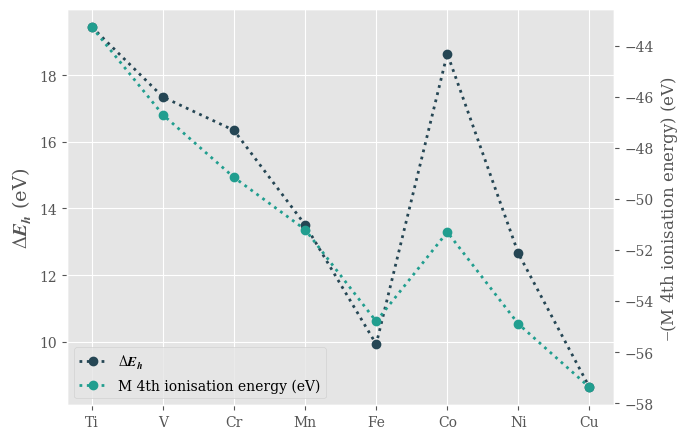

In [10]:
# Plot
x_data = range(len(first_row))
x_labels = [i['TM'] for i in first_row]

fig, ax1 = plt.subplots()

line1 = ax1.plot(x_data, delta_Eh_values, marker='o', c=clrs[0], ls='dotted', label='$\Delta E_h$')
ax1.set_ylabel('$\Delta E_h$ (eV)', size=14)

ax2 = ax1.twinx()
line2 = ax2.plot(x_data, ip_values, marker='o', c=clrs[1], ls='dotted', label='M 4th ionisation energy (eV)')
ax2.set_ylabel('$-$(M 4th ionisation energy) (eV)')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)
ax2.grid()

plt.xticks(x_data,x_labels)
plt.tight_layout()
plt.savefig('../Figures/First_row_deltaEh.png', dpi=300)
plt.show()